<a href="https://colab.research.google.com/github/Tiagoeem/Ensaio_Sobre_o_AutoML/blob/main/Auto_ML_PyCaret_Rain_Aus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Para medir o tempo de execução do script
import time
ini = time.time()

# Instalando PyCaret

Instalando módulos para suporte a GPU, treinamento demorou demais nos primeiros testes. [PyCaret on GPU](https://pycaret.readthedocs.io/en/latest/installation.html)

In [1]:
!pip install -U pandas-profiling

     |████████████████████████████████| 256kB 7.5MB/s 
     |████████████████████████████████| 1.1MB 12.8MB/s 
     |████████████████████████████████| 81kB 10.4MB/s 
     |████████████████████████████████| 10.1MB 27.9MB/s 
     |████████████████████████████████| 112kB 52.2MB/s 
     |████████████████████████████████| 645kB 41.9MB/s 
     |████████████████████████████████| 3.1MB 41.8MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
     |████████████████████████████████| 296kB 44.0MB/s 
  Created wheel for phik: filename=phik-0.11.2-cp37-none-any.whl size=1107413 sha256=5d4816bcdab7b51a1b8ec712ffac08ff07648e6e95f76f14afb4a034ad2ce324
  Stored in directory: /root/.cache/pip/wheels/c0/a3/b0/f27b1cfe32ea131a3715169132ff6d85653789e80e966c3bf6
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp37-none-any.whl size=27085 sha256=3ad0a014405d33496b15a339124b247611143874315030b0e8616066622245e2
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075

In [ ]:
!pip install pycaret

In [2]:
!/opt/conda-environments/rapids-stable/bin/python -m pip install --upgrade pycaret

/bin/bash: /opt/conda-environments/rapids-stable/bin/python: No such file or directory


In [4]:
# uninstall lightgbm CPU
!pip uninstall lightgbm -y

# install lightgbm GPU
!pip install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

Uninstalling lightgbm-2.2.3:
  Successfully uninstalled lightgbm-2.2.3
/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
     |████████████████████████████████| 1.5MB 7.0MB/s 
Skipping wheel build for lightgbm, due to binaries being disabled for it.
    Running setup.py install for lightgbm ... canceledERROR: Operation cancelled by user


In [ ]:
from pycaret.utils import enable_colab
enable_colab()

# Nota

Este notebook irá testar a performance da biblioteca Pycaret, será testado também a biblioteca H2O.ai em outro notebook ().

# Rain in Australia

Conjutno de dados - Rain in Australia: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

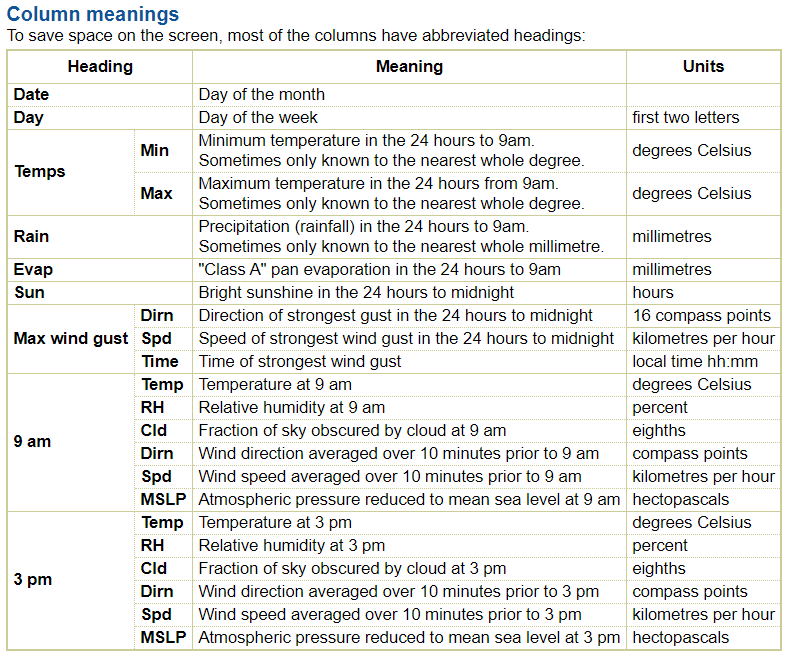

In [ ]:
# Baixa o csv a partir de um link para que qualquer pessoa possa executar sem maiores dificuldades
# Uniformiza o trabalho e facilita o compartilhamento de códigos e notebooks
# Realiza o download dos dados e extrai para uma pasta conhecida
import zipfile
import gdown
import os

parent_dir = '/content'

file_name = 'rain_aus.csv'
output = os.path.join( parent_dir, file_name )

if not(os.path.isfile(output)):
    url = 'https://drive.google.com/u/0/uc?id=1eT05yNu1TvSXlcEdrgAGKAx7bdEEMrLl'
    gdown.download(url, output=output, quiet=True)


In [ ]:
import pandas as pd

df_rain = pd.read_csv('rain_aus.csv')
df_rain.head(3)

In [ ]:
# Risk_mm é label para regressão, deve ser removido
df_rain.drop(labels='RISK_MM', axis='columns', inplace=True)

In [ ]:
df_rain.shape

# Análise Exploratória de Dados (EDA)

In [ ]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df_rain)
profile.to_notebook_iframe()

# Separação de dados

Por padrão o Pycaret separa os dados em Treino e teste (70%, 30%). Mas uma boa pratica é remover de 5% a 10% dos dados para uma validação final após finalização de todo o processo de modelagem e treinamento.

In [ ]:
df_validacao_final = df_rain.sample(frac=0.05, random_state=777)
df_rain.drop(df_validacao_final.index, inplace=True)
df_rain.reset_index(inplace=True, drop=True)

In [ ]:
print(df_rain.shape)
print(df_validacao_final.shape)

# Pycaret com Parâmetros Default

The **setup()** function initializes the environment in pycaret and creates the transformation pipeline to prepare the data for modeling and deployment. **setup()** must be called before executing any other function in pycaret. [Retirado do github oficial do PyCaret](https://github.com/pycaret/pycaret/blob/master/tutorials/Binary%20Classification%20Tutorial%20Level%20Beginner%20-%20%20CLF101.ipynb)

In [ ]:
from pycaret.classification import *

clf_default = setup(df_rain, target = 'RainTomorrow', session_id=1, log_experiment=True, experiment_name='Pycaret Default Values')

## Comparando modelos

 
"Comparing all models to evaluate performance is the recommended starting point for modeling once the setup is completed (unless you exactly know what kind of model you need, which is often not the case)." [Retirado do github oficial do PyCaret](https://github.com/pycaret/pycaret/blob/master/tutorials/Binary%20Classification%20Tutorial%20Level%20Beginner%20-%20%20CLF101.ipynb)

In [ ]:
best_model = compare_models()

## Criando Modelos Individuais (2: Cat e XgBoost)

### CatBoost

In [ ]:
# CatBoost
catboost = create_model('catboost')

### XgBoost

In [ ]:
# Random Forest
xgboost = create_model('xgboost')

## Tunando os Modelos

By default, tune_model optimizes Accuracy but this can be changed using optimize parameter. For example: tune_model(dt, optimize = 'AUC') will search for the hyperparameters of a Decision Tree Classifier that results in the highest AUC instead of Accuracy. [Retirado do github oficial do PyCaret](https://github.com/pycaret/pycaret/blob/master/tutorials/Binary%20Classification%20Tutorial%20Level%20Beginner%20-%20%20CLF101.ipynb)

### CatBoost

In [ ]:
tuned_cat = tune_model(catboost)

### XGBoost


In [ ]:
tuned_xgb = tune_model(xgboost)

## Validando os modelos (Métricas e Gráficos)


### Catboost

In [ ]:
plot_model(tuned_cat, plot='auc')

In [ ]:
plot_model(tuned_cat, plot = 'pr')

In [ ]:
plot_model(tuned_cat, plot='feature')

In [ ]:
plot_model(tuned_cat, plot = 'confusion_matrix')

### Random Forest

A função **evaluate_model()** inicia uma interface de usuário que permite a seleção do tipo de gráfico, permitindo a validação do modelo com todos as métricas disponíveis pelo PyCaret.

In [ ]:
evaluate_model(tuned_xgb)

## Avaliando os conjunto de **Teste**

Before finalizing the model, it is advisable to perform one final check by predicting the test/hold-out set and reviewing the evaluation metrics. [Retirado do github oficial do PyCaret](https://github.com/pycaret/pycaret/blob/master/tutorials/Binary%20Classification%20Tutorial%20Level%20Beginner%20-%20%20CLF101.ipynb)

### CatBoost

In [ ]:
predict_model(tuned_cat)

### XGBoost

In [ ]:
predict_model(tuned_xgb)

## Realizando a Calibração dos Modelos

Verificar se existe melhora.

In [ ]:
best_calib = calibrate_model(tuned_cat)

In [ ]:
predict_model(best_calib)

Observa-se uma melhora muito baixa, mas que usaremos mesmo assim.

Tunned CatBoost:

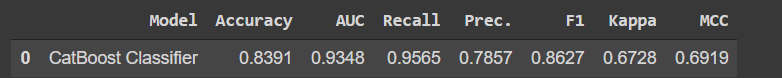


**Tunned + Calibrated CatBoost**

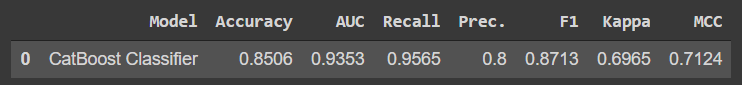

## Finalizando o modelo

Modelo escolhido: CatBoost

The finalize_model() function fits the model onto the complete dataset including the test/hold-out sample (30% in this case). The purpose of this function is to train the model on the complete dataset before it is deployed in production. [Retirado do github oficial do PyCaret](https://github.com/pycaret/pycaret/blob/master/tutorials/Binary%20Classification%20Tutorial%20Level%20Beginner%20-%20%20CLF101.ipynb)

In [ ]:
final_cat = finalize_model(best_calib)

In [ ]:
# Visualizando os parametros do modelo que irá para Deploy
final_cat.get_params()

## Validação dados nunca usados

In [ ]:
df_unseen = predict_model(final_cat, data=df_validacao_final)
df_unseen.head()

In [ ]:
from pycaret.utils import check_metric

check_metric(df_unseen['target'], df_unseen['Label'], metric = 'Accuracy')

# Salvando o modelo

In [ ]:
save_model(final_cat,'Final_Cat_16maio2021')

# Loading do Modelo (Exemplo)

In [ ]:
modelo_salvo_cat = load_model('/content/Final_Cat_16maio2021')

In [ ]:
predict_model(modelo_salvo_cat, data=df_unseen)

# Computando o tempo de execução

In [ ]:
fim = time.time()
print(fim - ini)